# Hierarchical radon model

(c) 2019 Thomas Wiecki, Junpeng Lao

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

In [2]:
@pm.model
def hierarchical_model(data, county_idx):
    # Hyperpriors
    mu_a = yield pm.Normal('mu_alpha', mu=0., sigma=1)
    sigma_a = yield pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = yield pm.Normal('mu_beta', mu=0., sigma=1)
    sigma_b = yield pm.HalfCauchy('sigma_beta', beta=1)

    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal('alpha', mu=mu_a, sigma=sigma_a, plate=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal('beta', mu=mu_b, sigma=sigma_b, plate=len(data.county.unique()))

    # Model error
    eps = yield pm.HalfCauchy('eps', beta=1)

    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal('y_like', mu=radon_est, sigma=eps, observed=data.log_radon)

In [3]:
%%time
init_num_chains = 50
model = hierarchical_model(data, county_idx)
pm4_trace, _ = pm.inference.sampling.sample(
    model, num_chains=init_num_chains, num_samples=10, burn_in=10, step_size=1., xla=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 49.9 s, sys: 3.35 s, total: 53.3 s
Wall time: 18.3 s


### Mass matrix adaptation
Essentially, we are doing a 2 window adaptation similar to Stan below: dual averaging for burn_in samples, and then normal sample for diagonal mass matrix estimation.

In [4]:
%%time
for i in range(3):
    step_size_ = []
    for _, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([init_num_chains] + std.shape, dtype=std.dtype))
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=init_num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i,
        step_size=step_size_, xla=False)

CPU times: user 2min 30s, sys: 10.4 s, total: 2min 40s
Wall time: 53.5 s


In [5]:
%%time
num_chains = 5
step_size_ = []
for _, x in pm4_trace.items():
    std = tf.math.reduce_std(x, axis=[0, 1])
    step_size_.append(
        std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

pm4_trace, sample_stat = pm.inference.sampling.sample(
    model, num_chains=num_chains, num_samples=500, burn_in=500,
    step_size=step_size_, xla=False)

CPU times: user 1min 10s, sys: 6.07 s, total: 1min 16s
Wall time: 30.4 s


In [6]:
az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)

In [7]:
np.mean(np.exp(az_trace.sample_stats['mean_tree_accept']), axis=1)

<xarray.DataArray 'mean_tree_accept' (chain: 5)>
array([0.657258, 0.645185, 0.768565, 0.800163, 0.85353 ], dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4

/home/canyon/miniconda3/envs/pymc4/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/canyon/miniconda3/envs/pymc4/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


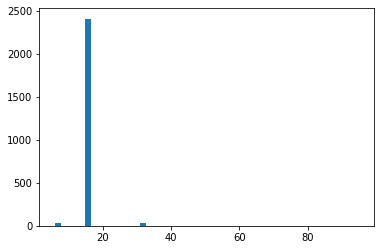

In [8]:
plt.hist(np.ravel(az_trace.sample_stats['tree_size']), 50);

In [9]:
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hierarchical_model/beta[0],-0.597,0.284,-1.113,-0.016,0.006,0.005,2033.0,1937.0,2063.0,967.0,1.01
hierarchical_model/beta[1],-0.785,0.243,-1.237,-0.309,0.008,0.006,979.0,811.0,1016.0,1199.0,1.01
hierarchical_model/beta[2],-0.627,0.263,-1.137,-0.148,0.006,0.004,1981.0,1915.0,1935.0,1692.0,1.00
hierarchical_model/beta[3],-0.681,0.246,-1.121,-0.194,0.006,0.005,1608.0,1391.0,1669.0,1298.0,1.01
hierarchical_model/beta[4],-0.600,0.284,-1.102,-0.037,0.006,0.005,2169.0,1960.0,2120.0,1264.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
hierarchical_model/alpha[82],1.652,0.171,1.339,1.983,0.004,0.003,2275.0,2210.0,2301.0,1574.0,1.00
hierarchical_model/alpha[83],1.611,0.169,1.307,1.947,0.003,0.002,3067.0,3023.0,3034.0,1759.0,1.00
hierarchical_model/alpha[84],1.420,0.260,0.886,1.849,0.004,0.003,3383.0,3222.0,3379.0,1561.0,1.00
hierarchical_model/__log_eps,-0.329,0.024,-0.375,-0.287,0.001,0.000,1291.0,1291.0,1317.0,1633.0,1.00


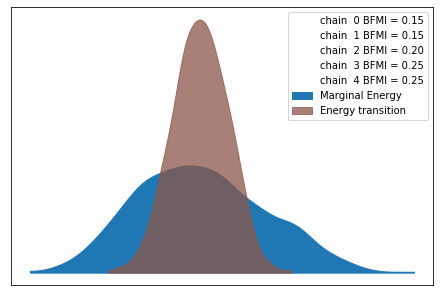

In [10]:
az.plot_energy(az_trace);

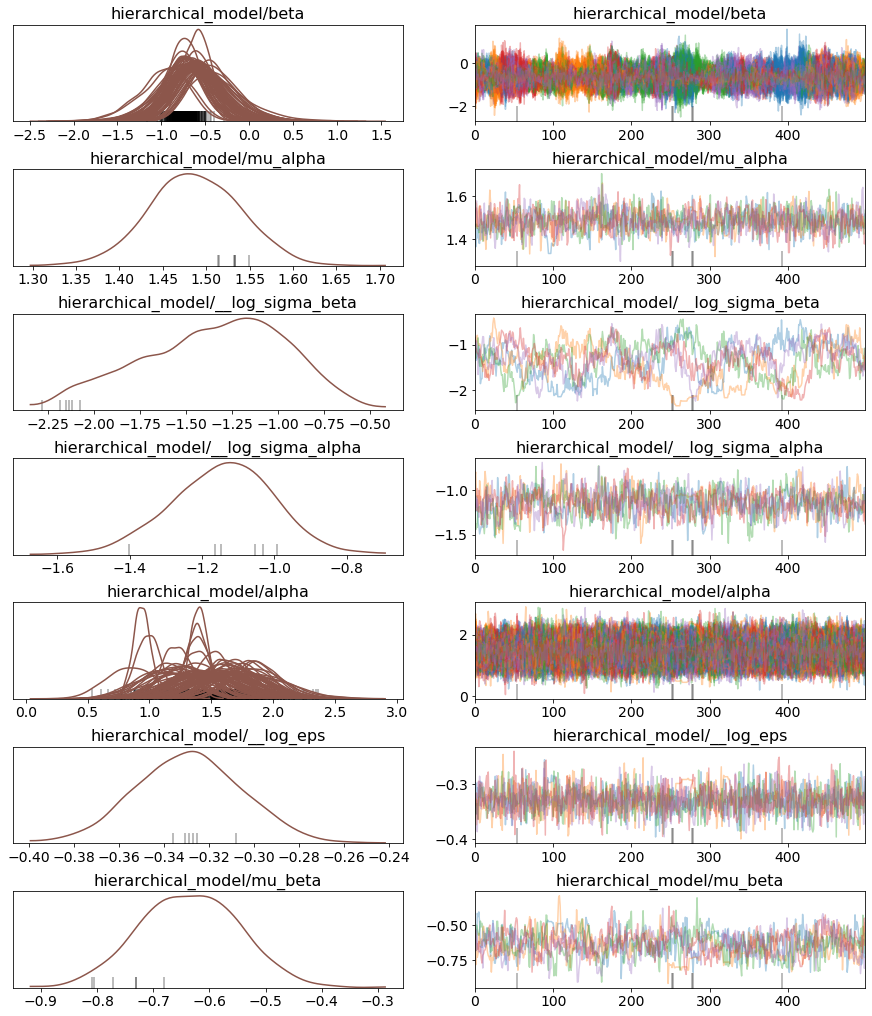

In [11]:
az.plot_trace(az_trace, compact=True, combined=True);